<a href="https://colab.research.google.com/github/Mathieu-Putz/Playing-with-PINNs/blob/main/4_PDE_1D_Diffusion_MSE_vs_n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import numpy as np  
import sympy as sy
from mpl_toolkits import mplot3d
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import statistics

# PINN applied to 1D Diffusion

In this notebook, I give a simple example of a physics informed neural network, by trying to approximate the solution to a PDE for 1D Diffusion. "Physics informed" in this case, means that we can leverage our knowledge about the boundary conditions to get better predictions for a given amount of data.

Let's imagine a thin tube stretching from x=0 to x=1. At t=0, a gas is spread through the tube, such that its concentration is given by the function f(x) = 1-4*(x-0.5)^2. I.e. there is a maximum at x=0.5 and at both ends of the tube the concentration is 0. Furthermore, let's impose the condition that the concentration at both ends be zero for all t. 

(Whether these are realistic boundary conditions is not of the essence for now.)

If we choose the right units, the diffusion will follow this PDE:

du/dt = d^2 u / dx^2

And the boundary conditions as described above are:

u(x,t=0) = f(x) = 1-4*(x-0.5)^2

u(0,t) = u(1, t) = 0

The analytical solution is known and we can use it to simulate gathering datapoints at random points. However, the exact solution is quite complicated and involves an infinite sum. I will only use the first few terms (exact number specified below) and I will not write out the full form here.

We will look at the domain where 0<=x<=1 and 0<=t<=0.3.


In this notebook, we want to explore how well the model performs for different amounts of training data and depending on whether or not we give it access to the boundary conditions.

## 1. Implementation of lots of functions - feel free to skip


This section contains the definitions for lots of functions which we will use later on in the program. I recommend skipping the section and coming back to it if you want to inspect implementations of specific things. (You can collapse sections in Colab by clicking the arrow left of the title.)

In [2]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

Tesla P100-PCIE-16GB
cuda


In [3]:
# time domain from 0 to:
t_dom = 0.3
# The correct solution involves the sum of an infinite series. The following
# variable indicates how many terms of that sum we calculate:
terms = 5

In [4]:
def define_random_points(n):
  # random timepoints, ordered chronologically:
  t = np.random.rand((n))*t_dom
  t.sort()
  # random positions in the tube:
  x = np.random.rand((n))
  # first col: time; second col: position
  pts = torch.Tensor([t,x]).T
  pts = pts.to(device)
  return pts

In [5]:
def define_boundaries(n_b_t, n_b_x):
  b_t     = torch.tensor([np.zeros(n_b_t),np.random.rand(n_b_t)]).T
  b_t, _  = torch.sort(b_t,0)
  b_x_1   = torch.tensor([t_dom*np.random.rand(n_b_x//2), np.zeros(n_b_x//2)]).T
  b_x_2   = torch.tensor([t_dom*np.random.rand(n_b_x//2), np.ones(n_b_x//2)]).T
  b_x     = torch.cat((b_x_1, b_x_2))

  b_t = b_t.to(device)
  b_x = b_x.to(device)
  return b_t, b_x

In [6]:
# f describes the concentration distribution at t=0
f = lambda y : 1 - 4*((y-0.5)**2)

In [7]:
def get_exact_solution(pts):
  x_dummy = sy.Symbol("x_dummy")
  def g(x_dummy, m):
    return f(x_dummy)*sy.sin(m*np.pi*x_dummy*1.0)
  b = lambda y ,m : 2*sy.integrate(g(y,m), (y,0,1))
  # This is the function we will try to approximate:
  h = 0
  for n in range(1,terms+1):
    B = b(x_dummy, n)
    B = float(B)
    h = h + B*torch.sin(n* np.pi * pts[:,1]) * torch.exp(- n**2 * np.pi**2* pts[:,0])
  return h

In [8]:
# Function to visualize values on a scatter plot 
def scatterplot(pts, values):
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  u_graph = values.cpu().detach().numpy()
  pts_x = pts[:,1]
  pts_x = pts_x.cpu().detach().numpy()
  pts_t = pts[:,0]
  pts_t = pts_t.cpu().detach().numpy()
  # Change view angle in following line:
  ax.view_init(30, 30)

  ax.scatter3D(pts_x,  pts_t,\
             u_graph , c=u_graph)
  ax.set_xlabel("x")
  ax.set_ylabel("t")
  ax.set_zlabel("u")

In [9]:
def add_noise_to_solution(u):
  u_size = u.size()
  noise = torch.normal(0, 0.15, size = u_size).to(device)
  return u + noise

In [10]:
def add_relative_noise(u):
  u = u + torch.normal(0.0,0.1*u)
  return u

In [11]:
def get_boundary_values(b_t, b_x):
  b_t_val = f(b_t[:,1])
  b_x_val = torch.zeros((b_x.size()[0]))

  #comment out to run on cpu:
  b_t_val = b_t_val.to(device)
  b_x_val = b_x_val.to(device)
  return b_t_val, b_x_val

In [12]:
def evaluate_model(n_eval):
  eval_pts = define_random_points(n_eval)

  # ground truth
  u_eval = get_exact_solution(eval_pts)

  # predictions
  pred_eval = model(eval_pts)
  pred_eval = pred_eval.squeeze()

  # return MSE
  return torch.mean((u_eval-pred_eval)**2)

In [13]:
def sketch(n_t, n_x, solution=True):
  # solution is a boolean determining whether we shall sketch the analytical 
  # solution (True) or the model predictions (False)

  fig = plt.figure()
  ax = plt.axes(projection='3d')
  # Make data.
  t_plot = np.linspace(0,t_dom, num=n_t)
  x_plot = np.linspace(0,1, num=n_x)
  t_plot, x_plot = np.meshgrid(t_plot, x_plot)

  # get solution or prediction
  t_plot = t_plot.reshape((n_t*n_x, ))
  x_plot = x_plot.reshape((n_t*n_x, ))
  pts = torch.Tensor([t_plot,x_plot]).T
  if solution:
    # get solution
    U_2d = get_exact_solution(pts)
  else:
    pts = pts.to(device)
    U_2d = model(pts).cpu()

  U_2d = U_2d.detach().numpy()

  t_plot = t_plot.reshape((n_t,n_x))
  x_plot = x_plot.reshape((n_t,n_x))
  U_2d = U_2d.reshape((n_t,n_x))

  if solution:
    print("This is the 'exact' solution we're trying to approximate:")
  else:
    print("This is our model's prediction:")
    
  # Plot the surface.
  surf = ax.plot_surface(t_plot, x_plot, U_2d, cmap=cm.coolwarm)

  # Customize the z axis.
  ax.set_zlim(-0.1, 1.01)
  ax.zaxis.set_major_locator(LinearLocator(10))
  # A StrMethodFormatter is used automatically

  # Add a color bar which maps values to colors.
  fig.colorbar(surf, shrink=0.5, aspect=5)

  ax.set_xlabel("t")
  ax.set_ylabel("x")
  ax.set_zlabel("u")

  plt.show()

In [14]:
def visualize_boundaries(n_t, n_x):
  
  b_t, b_x = define_boundaries(n_t, n_x)
  b_t_val, b_x_val = get_boundary_values(b_t, b_x)

  b_t = b_t.cpu().detach().numpy()
  b_x = b_x.cpu().detach().numpy()
  b_t_val = b_t_val.cpu().detach().numpy()
  b_x_val = b_x_val.cpu().detach().numpy()

  b = np.concatenate((b_t, b_x))
  b_val = np.concatenate((b_t_val,b_x_val))
  
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  
  # b__x means the x-coordinates of the total boundary b (t=0 plus x = 0)
  b__x = b[:,1]
  b__t = b[:,0]

  ax.scatter3D(b__t,  b__x,\
              b_val , c=b_val)
  ax.set_xlabel("t")
  ax.set_ylabel("x")
  ax.set_zlabel("u")

## 2. Illustrations of what we're doing

We're trying to approximate the function u(x,t) given at the very beginning. Here's what it looks like.

This is the 'exact' solution we're trying to approximate:


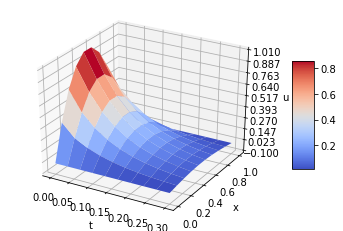

In [15]:
# The arguments of this function determine how precise the depiction is. 
# Specifically, they indicate how many points to illustrate along each axis.
sketch(10,10)

In order to approximate it, we need "datapoints". For this we will generate random points in the domain and get the value of the function at that point. Plus we add some noise. Here's an example of what the data could look like.

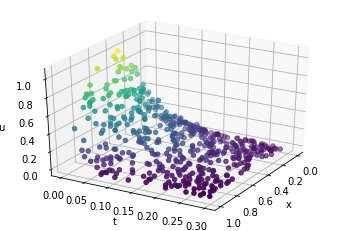

In [16]:
m_pts = define_random_points(500)
u = get_exact_solution(m_pts)
u = add_relative_noise(u)
scatterplot(m_pts, u)

Note that we can control the number of these datapoints. In fact the whole point of this notebook is to measure how the accuracy of our PINN scales with the number of datapoints.
To further illustrate this, here's what the data could look like if we had much less of it.

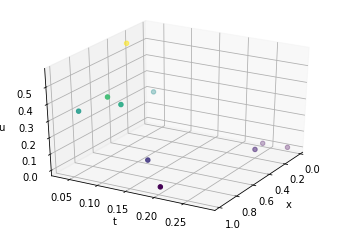

In [17]:
m_pts = define_random_points(10)
u = get_exact_solution(m_pts)
u = add_relative_noise(u)
scatterplot(m_pts, u)

However, this isn't all we have! What makes PINNs attractive, is that from knowing something about the physics, we effectively get some datapoints for free. In this case we know the boundary conditions. Recall that the initial concentration distribution through the tube is known and we also know that the concentration at each end is always zero.

To reemphasize this, if this weren't a contrived experiment, the "datapoints" you see above would have to be measured somehow. Maybe you would need to run a physical system. Or maybe you have a more complicated model on your computer, which is expensive to run and which you want to approximate. Thus, the datapoints would be expensive. On the other hand the points at the boundaries are free*. 

These boundary values will look something like this.

*) Note that when I say "free", I mean virtually free to acquire. Of course training the model on these points is still costly.

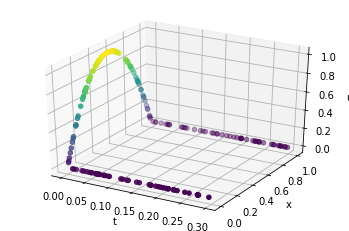

In [18]:
visualize_boundaries(100,100)

## 3. Defining the Neural Network

The point of this notebook is to compare performance with and without access to boundary conditions. Hence, in the following two cells, I define the functions such that access to boundary conditions can be controlled via the boolean bc.

In [19]:
class myNN(nn.Module):
  def __init__(self):
    super(myNN, self).__init__()
    self.model = nn.Sequential(
          nn.Linear(2, 20), 
          nn.ReLU(), 
          nn.Linear(20,200),
          nn.ReLU(),
          nn.Linear(200,20), 
          nn.ReLU(),
          nn.Linear(20,1)
    )
  def forward(self,x):
    return self.model(x)

learning_rate = 1e-4

# Loss function receives boolean bc, indicating whether to consider the boundary 
# conditions.
def loss(m_pts, u, bc, b_t, b_x, b_t_val, b_x_val,lambda_t, lambda_x):
  u_pred = model(m_pts)
  u_pred = u_pred.squeeze()
  if bc:
    u_pred_b_t  = model(b_t.float())
    u_pred_b_t  = u_pred_b_t.squeeze()
    u_pred_b_x  = model(b_x.float())   
    u_pred_b_x  = u_pred_b_x.squeeze()
    return torch.mean((u_pred - u)**2) \
            + lambda_t* torch.mean((u_pred_b_t - b_t_val)**2)  \
            + lambda_x* torch.mean((u_pred_b_x - b_x_val)**2)
  else:
    return torch.mean((u_pred - u)**2)

In [20]:
# The model can be trained with or without access to boundary conditions, 
# depending on the value of the boolean bc.
def train_model(m_pts, u, n_updates, bc=False, b_t=None, b_x=None, 
                b_t_val=None, b_x_val=None,lambda_t=None, lambda_x=None):
  #if bc==True:
  def closure():
    optimizer.zero_grad()
    l = loss(m_pts, u, bc, b_t, b_x, b_t_val, b_x_val, lambda_t, lambda_x)
    l.backward()
    return l

  for i in range(n_updates):
    optimizer.step(closure)
    if i%300 ==0:
      ls = loss(m_pts, u, bc, b_t, b_x, b_t_val, b_x_val, lambda_t, lambda_x)
      print(i, ": ", ls)

Now we have a Neural Network which can learn from datapoints and we can decide whether or not to consider boundary conditions. Let's try it!

0 :  tensor(0.4295, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
300 :  tensor(0.2030, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
600 :  tensor(0.0302, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
900 :  tensor(0.0115, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
1200 :  tensor(0.0047, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
1500 :  tensor(0.0021, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
This is our model's prediction:


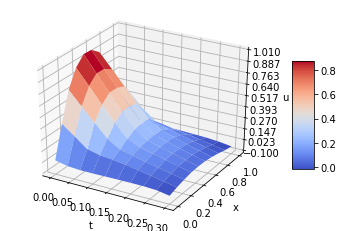

In [21]:
m_pts = define_random_points(200)
u = get_exact_solution(m_pts)
u = add_relative_noise(u)

n_b_t, n_b_x = 300, 2*150
b_t, b_x = define_boundaries(n_b_t, n_b_x)
b_t_val, b_x_val = get_boundary_values(b_t, b_x)

model = myNN()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

train_model(m_pts, u, 1501, True, b_t, b_x, b_t_val, b_x_val,1,1)

sketch(10,10,False)

Looking good!

## 4. Bringing it all together

We have all the necessary pieces to train and evaluate a model with a given number of training samples. That's what the following function does. And again, we can also control whether to consider boundary conditions via the boolean bc.

In [22]:
def get_MSE_for_n_samples(n_train, n_updates, bc):

  lambda_t, lambda_x = 1,1
  n_eval = 300

  m_pts = define_random_points(n_train)
  u = get_exact_solution(m_pts)
  u = add_relative_noise(u)

  if bc:
    n_b_t, n_b_x = 300, 2*150
    b_t, b_x = define_boundaries(n_b_t, n_b_x)
    b_t_val, b_x_val = get_boundary_values(b_t, b_x)
    train_model(m_pts, u, n_updates, True, b_t, b_x, b_t_val, b_x_val,lambda_t, 
                lambda_x)
  else:
    train_model(m_pts, u, n_updates)
  # return MSE
  return evaluate_model(n_eval)

The following cell contains the loop at the heart of this notebook. It creates, trains and evaluates a certain number (n_runs) of models, each with an increasing number of random datapoints to learn from (stored in m). For every number of random datapoints, we train one model with and one model without access to the boundary conditions.

Each model gets to learn for the same number of gradient updates n_updates. 

Subsequently, we store the MSE (Mean Squared Error) achieved on the evaluation points with each in MSEs_with (with access to boundary conditions) and MSEs_without (without access to boundary conditions); i.e. these are lists containing the MSE obtained during evaluation for different models trained with differing numbers of training points.

In [23]:
# define the number of runs, i.e. number of n_train,
# for each of which we will train and evaluate the model.
n_runs = 200
n_updates = 1501
factor_btwn_runs = 50**(1/(n_runs-1))

m = np.zeros((n_runs))
for i in range(n_runs):
  m[i] = np.round(1*(factor_btwn_runs**i))
m = m.astype(int)

MSEs_without = []
MSEs_with = []

for n_train in m:
  # 1. without boundary conditions
  model = myNN()
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  #train and evaluate that model
  MSE = get_MSE_for_n_samples(n_train, n_updates, bc = False).cpu()
  MSE = MSE.detach().numpy()
  MSEs_without.append(MSE)

  # 2. with boundary conditions
  # create new model
  model = myNN()
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  #train and evaluate that model
  MSE = get_MSE_for_n_samples(n_train, n_updates, bc = True).cpu()
  MSE = MSE.detach().numpy()
  
  MSEs_with.append(MSE)

0 :  tensor(0.0077, device='cuda:0', grad_fn=<MeanBackward0>)
300 :  tensor(5.5511e-17, device='cuda:0', grad_fn=<MeanBackward0>)
600 :  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
900 :  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
1200 :  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
1500 :  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
0 :  tensor(0.3494, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
300 :  tensor(0.1935, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
600 :  tensor(0.0555, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
900 :  tensor(0.0277, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
1200 :  tensor(0.0100, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
1500 :  tensor(0.0022, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
0 :  tensor(0.2276, device='cuda:0', grad_fn=<MeanBackward0>)
300 :  tensor(5.5289e-09, device='cuda:0', grad_fn=<MeanBackwa

## 5. Final result

Let's plot the results!

I chose to plot this on a log-log graph. This is for two reasons. 

First, it seems most intuitive to me to think of both the error and the number of datapoints in logarithmic terms. For instance, obviously the difference in performance between having access to 2 datapoints and 4 datapoints is expected to be much bigger than the difference between 300 and 302. 

Second, it turns out a power law seems to fit the data reasonably well.

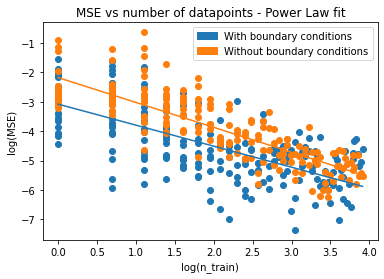

In [24]:
fig = plt.figure()
ax = fig.add_subplot()
log_m = np.log(m)
log_MSEs_with    = np.log(MSEs_with)
log_MSEs_without = np.log(MSEs_without)

ax.scatter(log_m, log_MSEs_with,c='#1f77b4')
ax.scatter(log_m, log_MSEs_without, c='#ff7f0e')

z = np.polyfit(log_m, log_MSEs_with, 1)
p = np.poly1d(z)
plt.plot(log_m,p(log_m),'#1f77b4')

w = np.polyfit(log_m, log_MSEs_without, 1)
q = np.poly1d(w)
plt.plot(log_m,q(log_m),'#ff7f0e')

ax.set_title("MSE vs number of datapoints - Power Law fit")
plt.ylabel("log(MSE)")
plt.xlabel("log(n_train)")

blue_patch   = mpatches.Patch(color='#1f77b4', label='With boundary conditions')
orange_patch = mpatches.Patch(color='#ff7f0e', label='Without boundary conditions')
plt.legend(handles=[blue_patch, orange_patch])

As expected, more data helps. Both with and without boundary conditions, it's clear the MSE gets smaller when the model is trained with more data.

The interesting part is comparing the orange with the blue curve. 

The models with access to boundary conditions perform significantly better for small amounts of training data. That makes sense! Having access to "free" points at the boundary is important when the model has little else to go on. As we feed more data, the difference starts vanishing.

# Conclusion

I think this notebook illustrates well that having access to boundary conditions can help a lot if gathering data is expensive.

# Appendix

To evaluate the model, we use a certain number (n_eval) of random points in the domain. This adds variance to the graph above: what we care about is performance on the whole domain, but we only measure it at a small set of points. 

Here I show that n_eval = 300 is a reasonable choice. 

The evaluation is still reasonably fast while the coefficient of variation between multiple evaluations of the same model (i.e. standard deviation divided by the mean) is below 10% in the example below. That example was chosen to be particularly unfavorable (only one datapoint apart from boundary condition --> relatively bad model --> where we measure makes a bigger difference). 

These 10% stand in contrast to much bigger performance differences between models trained under the same conditions and hence are acceptable.

In [25]:
model = myNN()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
#train and evaluate that model
MSE = get_MSE_for_n_samples(1, 1501, bc = True).cpu()
MSE = MSE.detach().numpy()
MSEs_eval = []
MSEs_eval.append(MSE)

0 :  tensor(0.3515, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
300 :  tensor(0.1565, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
600 :  tensor(0.0201, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
900 :  tensor(0.0022, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
1200 :  tensor(0.0004, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
1500 :  tensor(0.0001, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


In [26]:
for i in range(15):
  MSE = evaluate_model(300).cpu().detach().numpy()
  MSEs_eval.append(MSE)

Coefficient of variation:  0.04522759


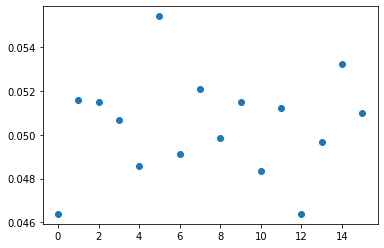

In [27]:
fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(np.arange(0,len(MSEs_eval),1), MSEs_eval)

print("Coefficient of variation: ", np.std(MSEs_eval)/np.mean(MSEs_eval))